In [322]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import sqrt
from  sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [299]:
df_data_pt_1 = pd.read_csv("Nomis Solutions_Data Part I.csv")
df_data_pt_1['car_type']=df_data_pt_1['Car  Type']
df_data_pt_1['previous_rate']=df_data_pt_1['Previous Rate']
df_data_pt_1['approve_date']=df_data_pt_1['Approve Date']
df_data_pt_1['competition_rate']=df_data_pt_1['Competition rate']
df_data_pt_1['cost_of_funds']=df_data_pt_1['Cost of Funds']


df_data_pt_1.drop(['Car  Type','Previous Rate','Approve Date','Competition rate','Cost of Funds'],axis=1,inplace=True)
df_data_pt_1.approve_date= pd.to_datetime(df_data_pt_1.approve_date)
df_data_pt_1.previous_rate = df_data_pt_1.previous_rate.apply(lambda x:0 if x == ' ' else float(x))
df_data_pt_2 = pd.read_csv("Nomis Solutions Part II.csv",skiprows=1)

## add in the year , month, and date to cluster against
df_data_pt_1['year'] = df_data_pt_1.approve_date.apply( lambda x: x.year)
df_data_pt_1['month'] = df_data_pt_1.approve_date.apply( lambda x: x.month)
df_data_pt_1['day'] = df_data_pt_1.approve_date.apply( lambda x: x.day)

## fix the naming with tier
df_data_pt_1['tier'] = df_data_pt_1.iloc[:,0]
df_data_pt_1 = df_data_pt_1.iloc[:,1:]

In [300]:
## create a dataframe without data to cluster against
df_data_copy = df_data_pt_1.copy()
df_data_pt_1_no_date = df_data_copy.loc[:,('tier', 'FICO', 'Term', 'Amount', 'Outcome', 'Rate', 'Partner Bin',\
       'car_type', 'previous_rate', 'competition_rate',\
       'cost_of_funds', 'year', 'month', 'day')]

In [301]:
# Drop NA columns
df_data_pt_1.dropna(inplace=True)


In [302]:
 #Drop na columns
df_data_pt_2.dropna(inplace=True)

In [303]:
df_data_pt_1_no_date.dropna(inplace=True)

In [304]:
df_data_pt_1_no_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208077 entries, 0 to 208078
Data columns (total 14 columns):
tier                208077 non-null float64
FICO                208077 non-null float64
Term                208077 non-null float64
Amount              208077 non-null float64
Outcome             208077 non-null float64
Rate                208077 non-null float64
Partner Bin         208077 non-null float64
car_type            208077 non-null object
previous_rate       208077 non-null float64
competition_rate    208077 non-null float64
cost_of_funds       208077 non-null float64
year                208077 non-null float64
month               208077 non-null float64
day                 208077 non-null float64
dtypes: float64(13), object(1)
memory usage: 23.8+ MB


In [305]:
df_data_no_date_dummy = pd.get_dummies(df_data_pt_1_no_date)

In [306]:
## round our values to four places
df_data_no_date_dummy = df_data_no_date_dummy.apply(lambda x:round(x,4))

In [307]:
df_data_no_date_dummy.head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,year,month,day,car_type_N,car_type_R,car_type_U
0,3.0,695.0,72.0,35000.0,0.0,7.49,1.0,0.0,6.25,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
1,1.0,751.0,60.0,40000.0,0.0,5.49,3.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
2,1.0,731.0,60.0,18064.0,0.0,5.49,3.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
3,4.0,652.0,72.0,15415.0,0.0,8.99,3.0,0.0,6.25,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
4,1.0,730.0,48.0,32000.0,0.0,5.49,1.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0


In [308]:
# Classify the customers we have into groups
knn_classifier = KMeans()

In [309]:
predicted_labels

array([5, 5, 0, ..., 6, 4, 0], dtype=int32)

In [310]:

first_sample = df_data_no_date_dummy.sample(10000)

In [311]:
fit_knn = knn_classifier.fit(X=first_sample)
predicted_labels = fit_knn.labels_
predicted_labels

array([3, 2, 1, ..., 1, 5, 5], dtype=int32)

In [312]:
## too large for this
silhouette_score(X=first_sample,labels=predicted_labels)

0.53820181612467777

In [233]:
def sample_silhouette_score(dataframe_input,max_size=20):
    """Run a three fold CV on 10,000 samples from the dataframe to determine the ideal number of clusters.
    Output is the ideal number of clusters of 3 CV folds with 10k samples."""
    silhouette_score_l = []
    for clusters in range(2,100):
        knn_classifier = KMeans(clusters)
        silhouette_scores_for_this_cluster = []
        for _ in range(3): ## CV for samples
            sample = dataframe_input.sample(10000)
            fit_knn = knn_classifier.fit(X=sample.values)
            predicted_labels = fit_knn.labels_
            silhouette_scores_for_this_cluster.append(silhouette_score(X=sample,labels=predicted_labels))
        silhouette_score_l.append(np.mean(silhouette_scores_for_this_cluster))
        print('Finished iteration {}'.format(clusters))
    number_of_clusters = [i for i in range(2,100)]
    plt.plot([i for i in range(2,100)],silhouette_score_l)
    plt.title('Ideal Number of Clusters')
    plt.ylabel('Silhouette score')
    plt.xlabel('Number of clusters')
    print('The best number of clusters is {}'.format(number_of_clusters[np.argmax(np.array(silhouette_score_l))]))
        
    

Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
Finished iteration 25
Finished iteration 26
Finished iteration 27
Finished iteration 28
Finished iteration 29
Finished iteration 30
Finished iteration 31
Finished iteration 32
Finished iteration 33
Finished iteration 34
Finished iteration 35
Finished iteration 36
Finished iteration 37
Finished iteration 38
Finished iteration 39
Finished iteration 40
Finished iteration 41
Finished iteration 42
Finished iteration 43
Finished iteration 44
Finished iteration 45
Finished iteration 46
Finished iteration

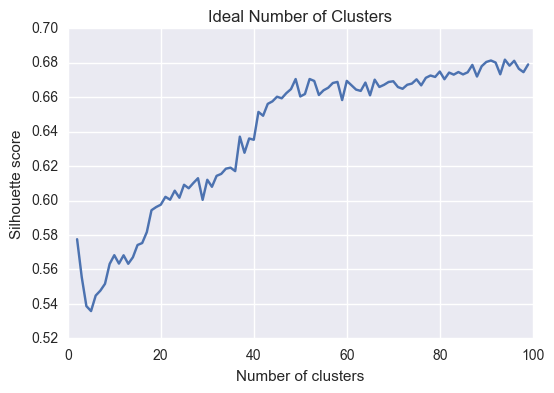

In [234]:
# This takes ~30 minutes to run
sample_silhouette_score(df_data_no_date_dummy)

- ~ Ninety is the ideal nuber of clusters here


In [260]:
def find_avg_centroid(dataframe_input,cluster_size=90):
    """Using the cluster size for the number of centers, find the centers in the dataset"""
    sample = dataframe_input
    knn_classifier = KMeans(cluster_size)
    fit_knn = knn_classifier.fit(X=sample.values)
    predicted_labels = fit_knn.labels_
    centers = fit_knn.cluster_centers_
    return centers



In [244]:
## store the cluster centers
average_cluster_centers = find_avg_centroid(df_data_no_date_dummy)

# Now, find the center that each row is closest to and assign to that cluster number.
- Define a euclidean distance function.

In [272]:
def euclidean_distance(a,b):
    """Expects numpy array and returns the euclidan distance between them"""
    return sqrt(sum((a-b)**2))

In [313]:

def assign_cluster_center(dataframe_input,centroids):
    """Take in a dataframe, iterate through the rows and find the closest center to each row.
    Returns the same dataframe with a new column indicating the closest cluster."""
    dataframe_input = dataframe_input.copy() 
    list_of_min_distances = []
    list_of_cluster_numbers = []
    for row in dataframe_input.iterrows():
        row_array=np.array(row[1])
        min_distance = 9999999999999999
        min_distance_cluster_number = 0

        for center_number,center in enumerate(centroids):
            center = np.array(center)
            distance = euclidean_distance(center, row_array)
            if distance < min_distance:
                min_distance = distance
                min_distance_cluster_number = center_number
        list_of_min_distances.append(min_distance)
        list_of_cluster_numbers.append(min_distance_cluster_number)
    dataframe_input['cluster_number']=list_of_cluster_numbers
    return dataframe_input
        


In [314]:
# create a new DF with added columns for the cluster it belongs to as well as distance to that cluster
df_data_clusters_dummy_no_date = assign_cluster_center(df_data_no_date_dummy,average_cluster_centers)

In [319]:
df_data_no_date_dummy.year.describe()

count    208077.000000
mean       2003.235456
std           0.668125
min        2002.000000
25%        2003.000000
50%        2003.000000
75%        2004.000000
max        2004.000000
Name: year, dtype: float64

In [317]:
df_data_no_date_dummy.head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,year,month,day,car_type_N,car_type_R,car_type_U
0,3.0,695.0,72.0,35000.0,0.0,7.49,1.0,0.0,6.25,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
1,1.0,751.0,60.0,40000.0,0.0,5.49,3.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
2,1.0,731.0,60.0,18064.0,0.0,5.49,3.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
3,4.0,652.0,72.0,15415.0,0.0,8.99,3.0,0.0,6.25,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0
4,1.0,730.0,48.0,32000.0,0.0,5.49,1.0,0.0,5.65,1.8388,2002.0,7.0,1.0,1.0,0.0,0.0


In [328]:
df_data_clusters_dummy_no_date[df_data_clusters_dummy_no_date.cluster_number==89].head()

,tier,FICO,Term,Amount,Outcome,Rate,Partner Bin,previous_rate,competition_rate,cost_of_funds,year,month,day,car_type_N,car_type_R,car_type_U,cluster_number


# Next, create a random forest prediction of outcome per cluster_number

In [326]:
list_of_clusters = [i for i in range(90)]

In [327]:
list_of_clusters

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89]

In [ ]:
for cluster_ in 

RandomForestClassifier